# __Cleaning the Data Scraped from Craigslist Rental Listings__
### W. W. Supplee 2020

In [2]:
#!/usr/bin/python3

import getLivedata as gl
import visualizeData as cl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import re
%matplotlib inline

In [3]:
df = pd.read_parquet('cleandata.parquet')

In [4]:
df.head()

,pid,date,neighborhood,title,bedrooms,bathrooms,sqft,url,price,attributes,latitude,longitude,pets,laundry,parking,EV_charging,$/sqft
0,7091649847,2020-03-11,Mountain View,"2br - 2/1, Park, Nature trail, Google access (...",2,1,950.0,https://sfbay.craigslist.org/pen/apa/d/mountai...,3020,applicat|apartmen|laundryi|nosmokin|carport|,37.395954,-122.067890,False,True,True,False,3.178947
1,7091643626,2020-03-11,Daly City,Updated Condo close to Serramonte shopping center,1,1,717.0,https://sfbay.craigslist.org/pen/apa/d/daly-ci...,1705,catsareo|dogsareo|furnishe|condo|w/dinuni|nosm...,37.664634,-122.463684,True,True,True,False,2.377964
2,7091648589,2020-03-11,San Mateo,3 Bedroom 3 Bath Condo Style Home (w/ Fireplac...,3,3,1425.0,https://sfbay.craigslist.org/pen/apa/d/san-mat...,5180,evchargi|applicat|catsareo|dogsareo|apartmen|w...,37.562354,-122.285813,True,True,True,True,3.635088
3,7091647413,2020-03-11,San Mateo,Spacious 1st Floor 1Bed/1Bath w/ Hardwood Floo...,1,1,807.0,https://sfbay.craigslist.org/pen/apa/d/san-mat...,3330,applicat|dogsareo|apartmen|w/dinuni|nosmokin|a...,37.558650,-122.285651,True,True,True,False,4.126394
4,7091646440,2020-03-11,San Mateo,Newly renovated 1st Floor 1Bed/1Bath w/ Hardwo...,1,1,807.0,https://sfbay.craigslist.org/pen/apa/d/san-mat...,3255,evchargi|applicat|catsareo|dogsareo|apartmen|w...,37.558650,-122.285651,True,True,True,True,4.033457


In [5]:
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 12)
df.describe()

,pid,bedrooms,bathrooms,sqft,price,latitude,longitude,$/sqft
count,1.742000...,1742.000000,1742.000000,1433.000000,1742.000000,1740.000000,1740.000000,1433.000000
mean,7.090949...,1.364524,1.246269,810.868807,3241.421929,37.518841,-122.261351,4.218406
std,4.291246...,0.768241,0.442793,246.716294,892.034037,0.095075,0.132450,0.880096
min,7.072154...,0.000000,1.000000,120.000000,680.000000,37.335807,-122.516742,1.123750
25%,7.090594...,1.000000,1.000000,650.000000,2625.000000,37.424500,-122.352781,3.689333
50%,7.091787...,1.000000,1.000000,768.000000,3140.000000,37.531976,-122.262556,4.118199
75%,7.093371...,2.000000,1.000000,975.000000,3710.000000,37.577773,-122.134476,4.667319
max,7.097142...,3.000000,3.000000,1460.000000,7000.000000,37.707235,-121.984400,10.000000


__While we're working to clean the data, let's work with a temporary copy of the dataframe:__

In [6]:
tf = df.copy()
tf['pets'] = tf.apply(lambda x : cl.PetsOK(x),axis=1)
tf['laundry'] = tf.apply(lambda x : cl.hasLaundry(x)>1,axis=1)
tf['parking'] = tf.apply(lambda x : cl.hasParking(x)>0,axis=1)
tf['EV_charging'] = tf.apply(lambda x : cl.hasEVcharging(x),axis=1)
print(tf)
tf.neighborhood.describe()

             pid        date neighborhood        title  bedrooms  bathrooms  \
0     7091649847  2020-03-11  Mountain...  2br - 2/...         2          1   
1     7091643626  2020-03-11    Daly City  Updated ...         1          1   
2     7091648589  2020-03-11    San Mateo  3 Bedroo...         3          3   
3     7091647413  2020-03-11    San Mateo  Spacious...         1          1   
4     7091646440  2020-03-11    San Mateo  Newly re...         1          1   
...          ...         ...          ...          ...       ...        ...   
2140  7097051554  2020-03-21  Mountain...  2x1 Grea...         2          1   
2141  7097055400  2020-03-21   Burlingame  Fuel you...         0          1   
2142  7097055268  2020-03-21  Foster City  WEEKENDS...         2          1   
2143  7097055116  2020-03-21   Burlingame  Looking ...         1          1   
2144  7097054630  2020-03-21    San Mateo  SPG is O...         0          1   

        sqft          url  price   attributes   lat

count            1742
unique             18
top       Mountain...
freq              301
Name: neighborhood, dtype: object

In [7]:
tf.neighborhood.value_counts()

Mountain View          301
San Mateo              263
Redwood City           215
Palo Alto              175
Daly City              172
Foster City            147
Menlo Park              91
Burlingame              69
Pacifica                67
South San Francisco     60
San Bruno               58
Belmont                 45
Millbrae                20
San Carlos              19
Los Altos               18
East Palo Alto          11
Half Moon Bay            6
Sunnyvale                5
Name: neighborhood, dtype: int64

__We can see already that some posts are either not on the peninsula (i.e. posted on the wrong forum) or otherwise outliers.  We will remove any category with <5 observations__    

In [8]:
byNeighborhood = tf.groupby('neighborhood')
outlier_index = byNeighborhood.filter(lambda x : len(x)<5).index
tf=tf.drop(outlier_index)
tf.neighborhood.value_counts()

Mountain View          301
San Mateo              263
Redwood City           215
Palo Alto              175
Daly City              172
Foster City            147
Menlo Park              91
Burlingame              69
Pacifica                67
South San Francisco     60
San Bruno               58
Belmont                 45
Millbrae                20
San Carlos              19
Los Altos               18
East Palo Alto          11
Half Moon Bay            6
Sunnyvale                5
Name: neighborhood, dtype: int64

In [9]:
tf.groupby('neighborhood')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
neighborhood,,,,,,,,
Belmont,45.0,2812.822222,611.764969,900.0,2534.00,2925.0,3001.00,4411.0
Burlingame,69.0,2918.753623,654.088801,899.0,2550.00,2831.0,3195.00,5115.0
Daly City,172.0,2694.063953,618.776128,1200.0,2348.75,2595.0,3258.75,4200.0
East Palo Alto,11.0,2285.909091,453.689421,1850.0,1950.00,2300.0,2497.50,3400.0
Foster City,147.0,3444.489796,601.122265,1633.0,2945.50,3385.0,3880.00,5845.0
Half Moon Bay,6.0,2866.500000,1098.459603,1000.0,2399.75,3249.5,3500.00,4000.0
Los Altos,18.0,3004.166667,951.050889,1390.0,2581.25,2995.0,3470.00,5500.0
Menlo Park,91.0,3495.879121,950.711416,1599.0,2732.50,3572.0,4020.00,5417.0
Millbrae,20.0,3101.250000,849.321517,1750.0,2493.75,2975.0,3446.25,5000.0


__Some records have data that is too incomplete to be usable.  (That is, the post URL did not have any useful information).  These records are caused by listings that have subsequently been flagged or removed.  We should remove them from our data set.__

In [10]:
outliers_index = tf[tf['bathrooms'] == 0].index
print(len(outliers_index),"listings have been subsequently removed or are not able to be parsed.")

0 listings have been subsequently removed or are not able to be parsed.


In [11]:
tf=tf.drop(outliers_index)
tf.describe()

,pid,bedrooms,bathrooms,sqft,price,latitude,longitude,$/sqft
count,1.742000...,1742.000000,1742.000000,1433.000000,1742.000000,1740.000000,1740.000000,1433.000000
mean,7.090949...,1.364524,1.246269,810.868807,3241.421929,37.518841,-122.261351,4.218406
std,4.291246...,0.768241,0.442793,246.716294,892.034037,0.095075,0.132450,0.880096
min,7.072154...,0.000000,1.000000,120.000000,680.000000,37.335807,-122.516742,1.123750
25%,7.090594...,1.000000,1.000000,650.000000,2625.000000,37.424500,-122.352781,3.689333
50%,7.091787...,1.000000,1.000000,768.000000,3140.000000,37.531976,-122.262556,4.118199
75%,7.093371...,2.000000,1.000000,975.000000,3710.000000,37.577773,-122.134476,4.667319
max,7.097142...,3.000000,3.000000,1460.000000,7000.000000,37.707235,-121.984400,10.000000


__Being craigslist, some posts are duplicates!  In the case of duplicates, we always keep the latest post in case of a price change or correction.  Let's drop the duplicates:__

In [12]:
duplicateView=tf.loc[:,['pid','title','bedrooms']]
duplicateView.sort_values(['pid'],ascending=True,inplace=True,axis=0)
print(duplicateView[duplicateView[['title','bedrooms']].duplicated(keep=False) == True].describe())
duplicates=tf.loc[duplicateView[['title','bedrooms']].duplicated(keep='last') == True]
print(len(duplicates),"entries are duplicates and will be dropped")
tf=tf.drop(duplicates.index)


       pid  bedrooms
count  0.0       0.0
mean   NaN       NaN
std    NaN       NaN
min    NaN       NaN
25%    NaN       NaN
50%    NaN       NaN
75%    NaN       NaN
max    NaN       NaN
0 entries are duplicates and will be dropped


In [13]:
tf.describe() # Let's see how many rentals are left

,pid,bedrooms,bathrooms,sqft,price,latitude,longitude,$/sqft
count,1.742000...,1742.000000,1742.000000,1433.000000,1742.000000,1740.000000,1740.000000,1433.000000
mean,7.090949...,1.364524,1.246269,810.868807,3241.421929,37.518841,-122.261351,4.218406
std,4.291246...,0.768241,0.442793,246.716294,892.034037,0.095075,0.132450,0.880096
min,7.072154...,0.000000,1.000000,120.000000,680.000000,37.335807,-122.516742,1.123750
25%,7.090594...,1.000000,1.000000,650.000000,2625.000000,37.424500,-122.352781,3.689333
50%,7.091787...,1.000000,1.000000,768.000000,3140.000000,37.531976,-122.262556,4.118199
75%,7.093371...,2.000000,1.000000,975.000000,3710.000000,37.577773,-122.134476,4.667319
max,7.097142...,3.000000,3.000000,1460.000000,7000.000000,37.707235,-121.984400,10.000000


__Note that some places for rent do not have area provided in the listings (usually listed in square feet -- our "sqft" column), but they still have rental price and bedroom data that are worth keeping them around for some subgroup analyses.  But just how many are there?  Well, they are marked by the value__ `sqft=-1`, __so let's see:__

In [14]:
tf[tf['sqft']<540].sqft.value_counts()

500.0    22
400.0    13
511.0     9
482.0     9
405.0     9
         ..
396.0     1
397.0     1
409.0     1
120.0     1
210.0     1
Name: sqft, Length: 40, dtype: int64

In [15]:
outliers_index=tf[tf['sqft']==-1].index
tf=tf.replace(-1,np.nan)
tf.at[tf['latitude']<1,'latitude']=np.nan
tf.at[tf['longitude']>=0,'longitude']=np.nan
tf.describe()

,pid,bedrooms,bathrooms,sqft,price,latitude,longitude,$/sqft
count,1.742000...,1742.000000,1742.000000,1433.000000,1742.000000,1740.000000,1740.000000,1433.000000
mean,7.090949...,1.364524,1.246269,810.868807,3241.421929,37.518841,-122.261351,4.218406
std,4.291246...,0.768241,0.442793,246.716294,892.034037,0.095075,0.132450,0.880096
min,7.072154...,0.000000,1.000000,120.000000,680.000000,37.335807,-122.516742,1.123750
25%,7.090594...,1.000000,1.000000,650.000000,2625.000000,37.424500,-122.352781,3.689333
50%,7.091787...,1.000000,1.000000,768.000000,3140.000000,37.531976,-122.262556,4.118199
75%,7.093371...,2.000000,1.000000,975.000000,3710.000000,37.577773,-122.134476,4.667319
max,7.097142...,3.000000,3.000000,1460.000000,7000.000000,37.707235,-121.984400,10.000000


__Let's look for outliers!  We will use the interquartile range method.__

In [16]:
IQR_sqft=tf.sqft.quantile(0.75) - tf.sqft.quantile(0.25)
IQR_sqft

325.0

In [17]:
tf[tf['sqft']<(tf.sqft.quantile(0.25)-1.5*IQR_sqft)].describe() # No low outliers

,pid,bedrooms,bathrooms,sqft,price,latitude,longitude,$/sqft
count,1.000000...,1.0,1.0,1.0,1.0,1.00000,1.000000,1.0
mean,7.095673...,1.0,1.0,120.0,1200.0,37.40334,-122.124174,10.0
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,7.095673...,1.0,1.0,120.0,1200.0,37.40334,-122.124174,10.0
25%,7.095673...,1.0,1.0,120.0,1200.0,37.40334,-122.124174,10.0
50%,7.095673...,1.0,1.0,120.0,1200.0,37.40334,-122.124174,10.0
75%,7.095673...,1.0,1.0,120.0,1200.0,37.40334,-122.124174,10.0
max,7.095673...,1.0,1.0,120.0,1200.0,37.40334,-122.124174,10.0


In [18]:
tf[tf['sqft']>(tf.sqft.quantile(0.75)+1.5*IQR_sqft)].describe() # How many outliers on the large side?

,pid,bedrooms,bathrooms,sqft,price,latitude,longitude,$/sqft
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
outliers_index = tf[tf['sqft']>(tf.sqft.quantile(0.75)+1.5*IQR_sqft)].index
tf.drop(outliers_index,inplace=True)

__It appears our data is right skewed in terms of rental property size, and we have dropped the extreme outliers (whiskers) that are >1.5 IQRs above the 75th percentile.__  

__Next let's check our data for any outliers geographically__

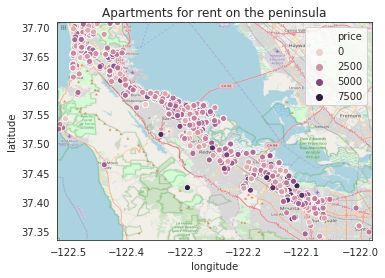

(-122.52, -121.98, 37.335, 37.708)

In [53]:
mapdata=plt.imread('./map.png')
sns.set_style('white')
ax=sns.scatterplot(x='longitude',y='latitude',hue='price',alpha=1,data=tf)
ax.set_ylim(37.335,37.708)
ax.set_xlim(-122.52,-121.980)
ax.set_title('Apartments for rent on the peninsula')
BBox=(-122.52, -121.980, 37.335, 37.708)
ax.imshow(mapdata, zorder=0,extent=BBox, aspect= 'equal')
#extent = BBox
plt.show()


Let's remove the apartments which are clearly NOT in our region!

In [21]:
outliersIndex = tf[tf['longitude']>-121].index
tf.drop(outliersIndex,inplace=True)

Let's try that plot again.

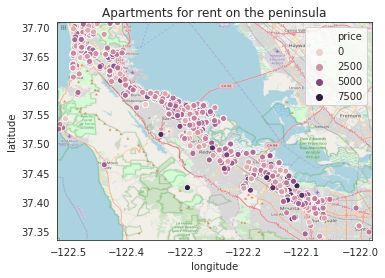

In [128]:
sns.set_style('white')
ax=sns.scatterplot(x='longitude',y='latitude',hue='price',alpha=1,data=tf)
mapdata=plt.imread('./map.png')
ax.set_ylim(37.335,37.708)
ax.set_xlim(-122.52,-121.980)
ax.set_title('Apartments for rent on the peninsula')
BBox=(-122.52, -121.980, 37.335, 37.708)
ax.imshow(mapdata, zorder=0,extent=BBox, aspect= 'equal')
#extent = BBox
plt.show()

__Next, let's create columns (of Boolean type) based on the attributes scraped from the listings.__

In [23]:
tf['$/sqft'] = tf.apply(lambda x : x.price/x.sqft or np.nan,axis=1)

In [24]:
pd.set_option('display.max_colwidth', 16)

In [25]:
byLaundry = tf.groupby('laundry')
byLaundry.describe()

pid                                                          \
          count          mean           std           min           25%   
laundry                                                                   
False     576.0  7.090469e+09  4.816708e+06  7.072154e+09  7.088740e+09   
True     1166.0  7.091186e+09  3.987227e+06  7.072203e+09  7.090892e+09   

                                                  bedrooms            \
                  50%           75%           max    count      mean   
laundry                                                                
False    7.091535e+09  7.093375e+09  7.097131e+09    576.0  1.227431   
True     7.091831e+09  7.093369e+09  7.097142e+09   1166.0  1.432247   

                                           bathrooms                           \
              std  min  25%  50%  75%  max     count      mean       std  min   
laundry                                                                         
False    0.752048  0.0  1.0  1.0  2.0  3.0     576.0  1.142361  0.354662  1.0   
True     0.767442  0.0  1.0  1.0  2.0  3.0    1166.0  1.297599  0.472173  1.0   

                              sqft                                        \
         25%  50%  75%  max  count        mean         std    min    25%   
laundry                                                                    
False    1.0  1.0  1.0  3.0  447.0  724.624161  220.750559  120.0  570.0   
True     1.0  1.0  2.0  3.0  986.0  849.967546  248.034321  225.0  685.0   

                                 price                                  \
           50%     75%     max   count         mean         std    min   
laundry                                                                  
False    700.0   850.0  1400.0   576.0  2865.848958  797.086316  899.0   
True     790.0  1042.5  1460.0  1166.0  3426.953688  878.277991  680.0   

                                        latitude                       \
            25%     50%     75%     max    count       mean       std   
laundry                                                                 
False    2395.0  2729.0  3250.0  7000.0    575.0  37.518888  0.105161   
True     2795.0  3395.0  3920.0  6500.0   1165.0  37.518819  0.089728   

                                                               longitude  \
               min        25%        50%        75%        max     count   
laundry                                                                    
False    37.358790  37.408622  37.531865  37.628585  37.707235     575.0   
True     37.335807  37.439600  37.535836  37.572135  37.706844    1165.0   

                                                                               \
               mean       std         min         25%         50%         75%   
laundry                                                                         
False   -122.262802  0.149019 -122.516742 -122.420336 -122.255778 -122.127400   
True    -122.260635  0.123519 -122.514832 -122.334080 -122.263778 -122.154239   

                    $/sqft                                                   \
                max  count      mean       std      min       25%       50%   
laundry                                                                       
False   -122.001532  447.0  4.129610  0.930386  1.12375  3.541176  3.947740   
True    -121.984400  986.0  4.258661  0.853773  1.30000  3.746439  4.183285   

                              
              75%        max  
laundry                       
False    4.531915  10.000000  
True     4.693287   8.056667

__We want to create a model which can predict price.  Let's use a heatmap to see which statistics are most correlated.__

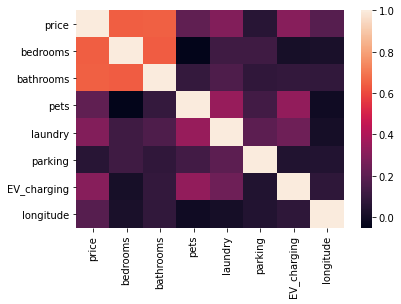

In [26]:
cl.generateHeatmap(tf,['price','neighborhood','bedrooms','bathrooms','pets','laundry','parking','EV_charging','longitude'])

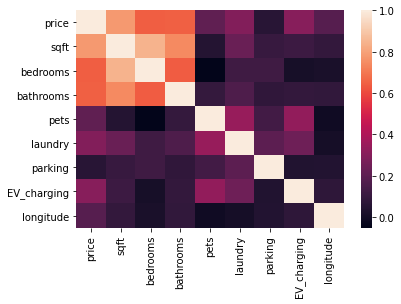

In [27]:
cl.generateHeatmap(tf,['price','sqft','bedrooms','bathrooms','pets','laundry','parking','EV_charging','longitude'])

__Finally, let's look at some descriptive statistics__

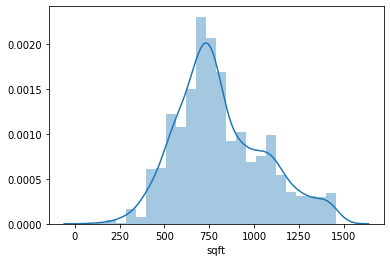

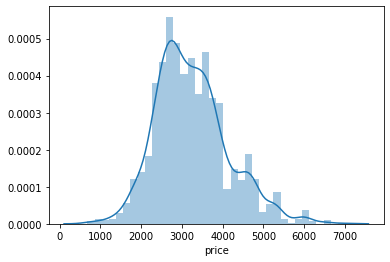

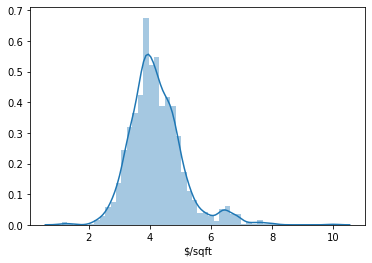

<Figure size 432x288 with 0 Axes>

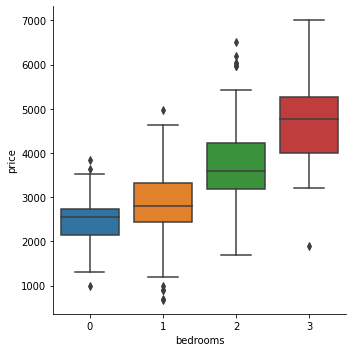

<Figure size 432x288 with 0 Axes>

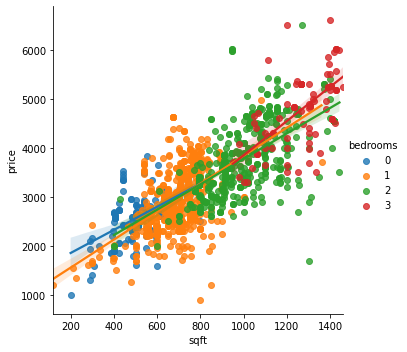

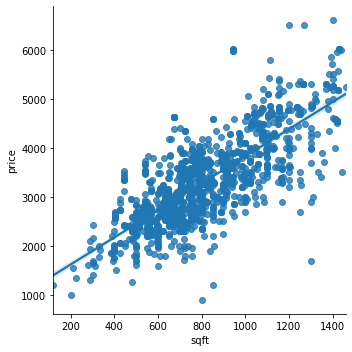

In [28]:
fig1=sns.distplot(tf.sqft)
plt.figure()
fig2=sns.distplot(tf.price)
plt.figure()
fig4=sns.distplot(tf['$/sqft'])
plt.figure()
fig3=sns.catplot(kind='box',x='bedrooms',y='price',data=tf)
plt.figure()
outliersIndex = tf[tf['sqft']>(tf.sqft.quantile(0.75)+1.5*(tf.sqft.quantile(0.75)-tf.sqft.quantile(0.25)))].index
tf.drop(outliersIndex,inplace=True)
reg=sns.lmplot(x='sqft',y='price',hue='bedrooms',data=tf[tf['bedrooms']<4])
reg=sns.lmplot(x='sqft',y='price',data=tf[tf['bedrooms']<4])

In [29]:
tf.bedrooms.value_counts()

1    864
2    566
0    185
3    127
Name: bedrooms, dtype: int64

In [30]:
outliersIndex = tf[tf['bedrooms']>3].index
tf.drop(outliersIndex,inplace=True)

In [155]:
#from scipy import stats
import statsmodels.api as sm
from sklearn import preprocessing
from sklearn import pipeline
from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn import metrics
min_max_scaler = preprocessing.MinMaxScaler()
areaTable=tf[tf['sqft']>0].copy()
areaNumbers = areaTable.loc[:,['bedrooms','bathrooms','sqft','pets','laundry','EV_charging','price']]
pipeline = Pipeline(steps=[('power', PowerTransformer()), ('model', HuberRegressor(epsilon=1))])

# prepare the model with target scaling
model = TransformedTargetRegressor(regressor=pipeline, transformer=PowerTransformer())

areaTable_normalized = pd.DataFrame(areaNumbers,columns=areaNumbers.columns)
areaTable_normalized['sqft_scaled'] = areaTable_normalized.apply(lambda x : x.sqft*(1/100),axis=1)
X=np.array(areaTable_normalized[['bedrooms','bathrooms','sqft_scaled','pets','laundry','EV_charging']], dtype=float)
#X=sm.add_constant(X,prepend=True)
y=np.array(areaTable_normalized['price'],dtype=float)
#print(X)

# evaluate model
cv = KFold(n_splits=30, shuffle=True)
predictions = cross_val_predict(model, X, y, cv=cv)
residual=y-predictions
areaTable=areaTable.assign(predicted=predictions)
areaTable=areaTable.assign(residual=residual)
accuracy=metrics.r2_score(y,predictions)
print("This model accounts for %2.1f %% of variation in price seen" % (accuracy*100))

#M=sm.robust.norms.HuberT()
#model=HuberRegressor()
#HuberRegressor.set_params(model,epsilon=2,fit_intercept=True)
#train_model=model.fit(X,y)
#predictions=train_model.predict(X)
#r2=train_model.score(X,y)
#print(r2)



This model accounts for 67.9 % of variation in price seen


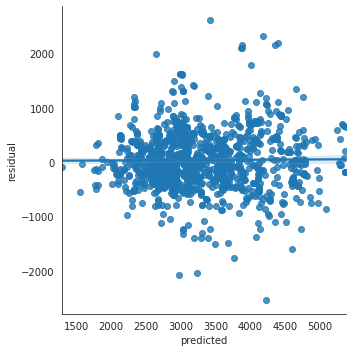

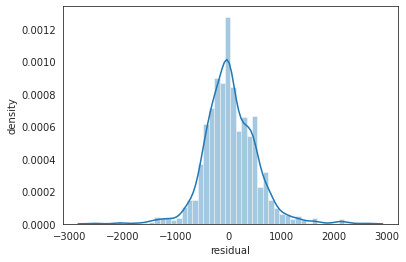

Standard deviation of the error: 492.7


In [160]:
ax=sns.lmplot(x='predicted',y='residual',data=areaTable)
plt.show()
ax=sns.distplot(areaTable.residual)
plt.ylabel('density')
plt.show()
print("Standard deviation of the error: %2.1f" % (areaTable.residual.std()))

__Well, that's it!  We have now assessed all the craigslist posts according to a multivariate linear regression and the final column represents the 'residual' (actual price - predicted price).  The lower the residual (the more negative), the better our model thinks the craigslist asking price to be!  That is, listings where `residual < 0` are "good deals".  Posts where `residual` is two standard deviations or greater should be regarded as suspicious.__

In [35]:
tf.to_parquet('cleandata.parquet')
tf.to_csv('cleandata_debug.csv')

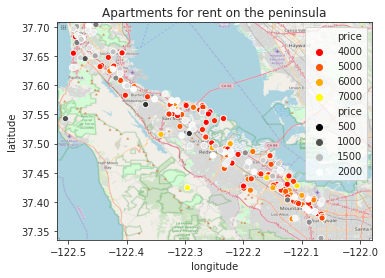

In [185]:
sns.set_style('ticks')
mapdata=plt.imread('./map.png')
ax=sns.scatterplot(x='longitude',y='latitude',hue='price',palette='autumn',data=tf[tf['price']>4000])
ax=sns.scatterplot(x='longitude',y='latitude',hue='price',palette='Greys_r',data=tf[tf['price']<2000])
ax.set_ylim(37.335,37.708)
ax.set_xlim(-122.52,-121.980)
ax.set_title('Apartments for rent on the peninsula')
BBox=(-122.52, -121.980, 37.335, 37.708)
ax.imshow(mapdata, zorder=0,extent=BBox, aspect= 'equal')
plt.show()

In [186]:
outliersIndex = tf[tf['latitude']>37.75].index
tf.drop(outliersIndex,inplace=True)
tf.to_parquet('cleandata.parquet')
areaTable.to_parquet('linearmodel-sqft.parquet')